### Summary: Refactoring Experiments 2 notebook for classification task

- It is told that classification can achieve 0.90 LB:

https://www.kaggle.com/c/humpback-whale-identification/discussion/74647

https://www.kaggle.com/c/humpback-whale-identification/discussion/75846#452220

- Strategies that might work: 

https://www.kaggle.com/c/humpback-whale-identification/discussion/74402#443160

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *
from ipyexperiments import *

In [3]:
data_path = Path('../data/whale/')

In [4]:
sorted(data_path.ls())

[PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/cropped_training'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/test'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/train_csv_2.csv')]

In [5]:
train = pd.read_csv(data_path/'train.csv')

In [6]:
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
# whale id image counts - number of whale ids with only single image
w_counts = train.groupby(['Id'])['Id'].count().sort_values(ascending=False)
print(f"number of whale ids with single image: {sum(w_counts == 1)}")
print(f"number of unique whale ids in training: {len(w_counts)}")
w2counts = dict(w_counts)
counts2w = {w2counts[k]:k for k in w2counts}
w2fnames = dict(train.groupby(['Id'])['Image'].apply(lambda x: list(x)))

number of whale ids with single image: 2073
number of unique whale ids in training: 5005


In [8]:
list(w2fnames.items())[-5:]

[('w_ff94900', ['5ac086036.jpg']),
 ('w_ffa542b', ['4f9e431aa.jpg', '8abea550e.jpg', 'cd3a073a2.jpg']),
 ('w_ffa6d42', ['9dd320bb3.jpg']),
 ('w_ffcf5fe', ['d3967e1df.jpg']),
 ('w_ffe8693', ['df4bbd82a.jpg'])]

# Databunch

In [9]:
# classes
idx2w = dict(enumerate(w2counts.keys()))
w2idx = {idx2w[k]:k for k in idx2w}
classes = list(w2counts.keys())

In [10]:
classes[:3], len(classes)

(['new_whale', 'w_23a388d', 'w_9b5109b'], 5005)

In [11]:
# Validation fnames
np.random.seed(42)
train_fnames = []
valid_fnames = []
val_ratio = 0.1
for _, fnames in w2fnames.items():
    if len(fnames) == 1:
        train_fnames += fnames
    else:
        n = len(fnames)
        n_val = max(1, int(n*val_ratio)) 
        fnames = np.random.permutation(fnames)
        train_fnames += list(fnames[n_val:])
        valid_fnames += list(fnames[:n_val])

len(train_fnames), len(valid_fnames)

train_df = train[train.Image.isin(train_fnames)].reset_index(drop=True)
valid_df = train[train.Image.isin(valid_fnames)].reset_index(drop=True)

print(f"unique classes in train : {train_df['Id'].nunique()}")
print(f"unique classes in valid: {valid_df['Id'].nunique()}")
print(f"unique classes with single image: {train_df['Id'].nunique() - valid_df['Id'].nunique()}")

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


In [12]:
def get_data(train_df,
             valid_fnames,
             bs=64,
             size=(112,224),
             train_folder='cropped_training',
             test_folder='cropped_test',
             stats=imagenet_stats):
    """
    cosntruct from dataframe [Image, Id] and validation fnames from Image col
    """
    itemlist = ImageItemList.from_df(train_df, data_path, folder=train_folder,
                                     cols=['Image'])
    itemlists = itemlist.split_by_valid_func(lambda item: True if
                                             Path(item).name in valid_fnames else False)
    labellists = itemlists.label_from_df()
    labellists = labellists.add_test(ImageItemList.from_folder(data_path/test_folder))
    data = (labellists.transform(get_transforms(do_flip=False,
                                                max_zoom=0,
                                                max_warp=0.1),
                                 size=size,
                                 resize_method=ResizeMethod.SQUISH, 
                                 # ResizeMethod.SQUISH forces (112, 224) to (128,224)
                                 padding_mode='border')
                      .databunch(bs=bs, num_workers=8)
                      .normalize(stats))
    return data

In [13]:
train.head(2)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [14]:
data = get_data(train, valid_fnames=valid_fnames, size=(224,448))

torch.Size([3, 224, 448])


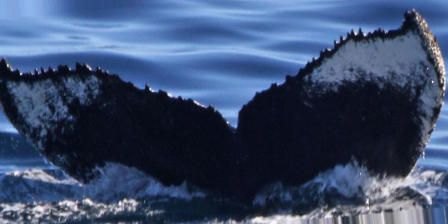

In [15]:
i = 10
print(data.train_ds[i][0].data.size()); data.train_ds[i][0]

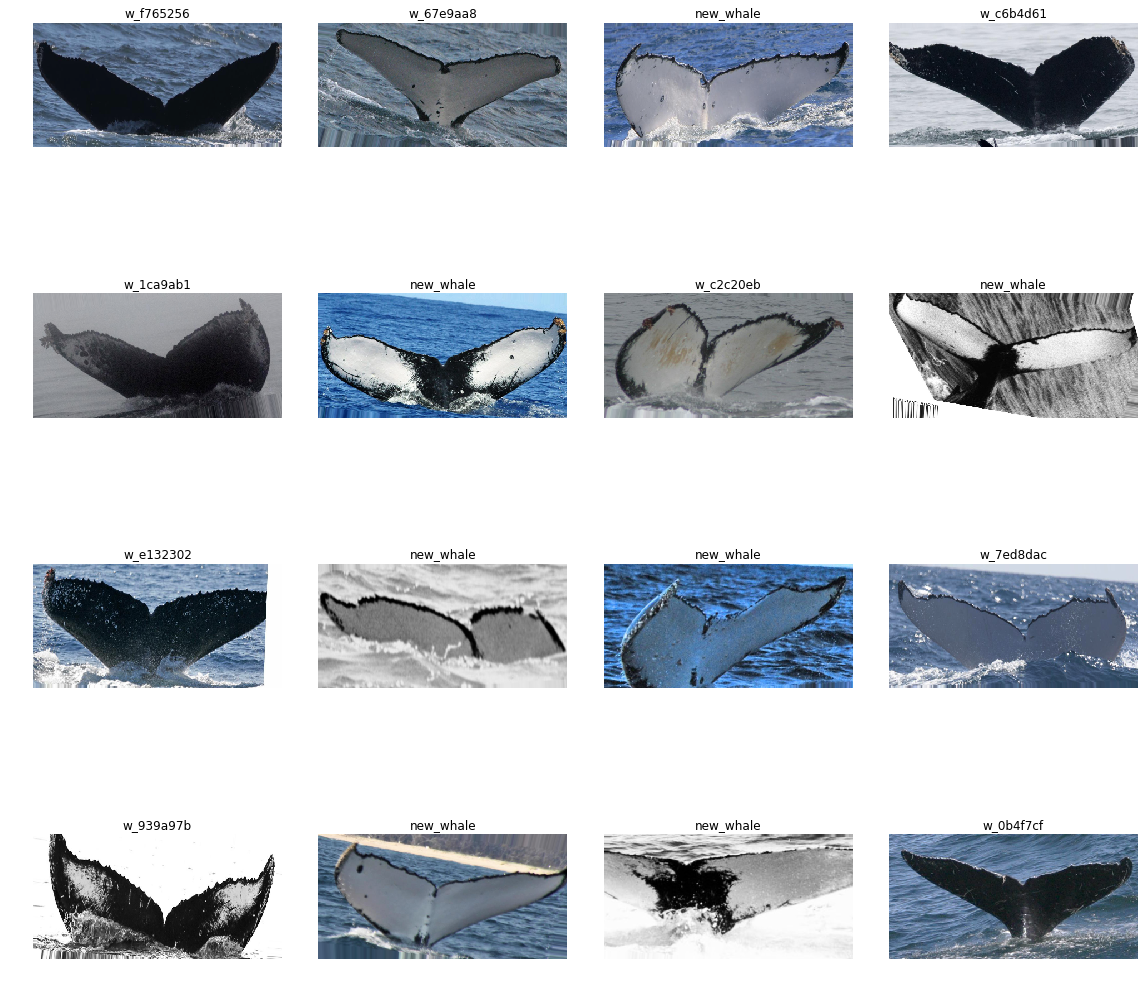

In [16]:
data.show_batch(rows=4, ds_type=DatasetType.Train)

# Training

In [16]:
from utils import map5
from fastai.callbacks import EarlyStoppingCallback, TerminateOnNaNCallback
from fastai.train import BnFreeze
from fastai.callbacks import ReduceLROnPlateauCallback

In [17]:
# validation baseline accuracy
np.mean(train[train['Image'].isin(valid_fnames)]['Id'] == 'new_whale')

0.2401193139448173

In [18]:
# define calllbacks
early_stopping = partial(EarlyStoppingCallback, monitor="map5", mode="max", patience=10)
terminate_nan = TerminateOnNaNCallback()
reduce_lr = partial(ReduceLROnPlateauCallback, monitor="map5", mode='max',
                    patience=5, factor=0.7)

### Different data strategies

In [19]:
# DATA 1: all classes (including new whale) data
train_all_classes_df = train.copy()
train_all_classes_df.shape

(25361, 2)

In [20]:
# DATA 2: only known classes (excluding new whale) data
train_known_classes_df = train_all_classes_df[train['Id'] != "new_whale"].reset_index(drop=True)
train_known_classes_df.shape

(15697, 2)

In [21]:
# DATA 3: upsampled only known classes (excluding new whale) data
train_known_classes_df_trn = train_known_classes_df[train_known_classes_df['Image'].isin(train_fnames)]
train_known_classes_df_val = train_known_classes_df[train_known_classes_df['Image'].isin(valid_fnames)]

sample_to = 20
grouped = train_known_classes_df_trn.groupby('Id')
upsampled_train_known_classes_df_trn = grouped.apply(lambda x: x if len(x) > sample_to 
                                   else x.sample(sample_to, replace=True))
upsampled_train_known_classes_df = pd.concat([upsampled_train_known_classes_df_trn,
                                       train_known_classes_df_val]).reset_index(drop=True)
upsampled_train_known_classes_df.shape

(103763, 2)

In [22]:
upsampled_train_known_classes_df.groupby("Id").count().min()

Image    20
dtype: int64

In [23]:
upsampled_train_known_classes_df.groupby("Id").count()['Image'].value_counts()

21    2865
20    2073
22      19
24       7
23       4
40       3
30       3
37       3
31       3
45       2
34       2
25       2
29       2
36       1
32       1
33       1
48       1
51       1
49       1
57       1
47       1
65       1
73       1
50       1
54       1
62       1
27       1
35       1
61       1
Name: Image, dtype: int64

### Training 1

- **1)** Train `112x224` with val determine n_epochs
- **2)** Train `168x336` with val determine n_epochs
- **3)** Train `224x448` with val determine n_epochs
- **4)** Train `oversampled 112x224` with val determine n_epochs
- **5)** Train `oversampled 168x336` with val determine n_epochs
- **6)** Train `oversampled 224x448` with val determine n_epochs

In [24]:
valid_known_fnames = [fn for fn in valid_fnames if fn not in w2fnames['new_whale']]; len(valid_known_fnames)

3057

In [25]:
# baseline accuracy by majority class 
train[train.Image.isin(valid_known_fnames)]['Id'].value_counts(True).head(1)

w_23a388d    0.00229
Name: Id, dtype: float64

#### 1) 112x224

In [27]:
data = get_data(train_known_classes_df,
                bs=128,
                valid_fnames=valid_fnames,
                size=(112,224))
len(data.train_ds), len(data.valid_ds)

(12640, 3057)

In [28]:
learner = create_cnn(data=data,
                     arch=models.resnet50,
                     lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     callback_fns=[early_stopping, BnFreeze],
                     callbacks = [terminate_nan])

In [336]:
learner.fit_one_cycle(100, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,8.350357,8.097118,0.023880,0.035443
2,7.026175,7.668344,0.046451,0.061122
3,5.950034,7.310153,0.073602,0.092716
4,4.993258,6.882789,0.088322,0.116710
5,4.049290,6.421446,0.118090,0.148343
6,3.092342,6.109218,0.137390,0.176153
7,2.176610,5.979919,0.154073,0.197639
8,1.456196,6.065742,0.160288,0.205256
9,1.100716,6.312384,0.164213,0.211787
10,1.019056,6.699831,0.169447,0.215582


In [337]:
learner.save("res50-112x224-stage1")

In [338]:
learner.unfreeze()

In [339]:
learner.fit_one_cycle(1000, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,map5
1,0.002993,6.364194,0.432450,0.489968
2,0.002598,6.352267,0.435394,0.491729
3,0.004535,6.377889,0.429506,0.488327
4,0.003617,6.377455,0.434413,0.490819
5,0.004021,6.360255,0.434740,0.491822
6,0.002783,6.334376,0.432450,0.491511
7,0.002317,6.339766,0.436703,0.493332
8,0.001873,6.347588,0.435394,0.493049
9,0.003288,6.339490,0.433104,0.490982
10,0.004643,6.316658,0.434740,0.491888


Epoch 18: early stopping


In [340]:
learner.save("res50-112x224-stage2")

#### 2) 168x336

In [35]:
data = get_data(train_known_classes_df,
                bs=64,
                valid_fnames=valid_fnames,
                size=(168, 336))
len(data.train_ds), len(data.valid_ds)

(12640, 3057)

In [36]:
learner = create_cnn(data=data,
                     arch=models.resnet50,
                     lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     callback_fns=[early_stopping, BnFreeze],
                     callbacks = [terminate_nan])

In [37]:
learner.load("res50-112x224-stage2");

In [38]:
learner.data.train_ds.tfmargs

{'size': (168, 336),
 'resize_method': <ResizeMethod.SQUISH: 3>,
 'padding_mode': 'border'}

In [39]:
learner.freeze_to(-1)

In [41]:
learner.fit_one_cycle(1000, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,0.120172,6.990629,0.380765,0.435814
2,0.089122,6.860706,0.388943,0.445159
3,0.058548,6.769140,0.390906,0.447454
4,0.053408,6.688273,0.397448,0.453473
5,0.037594,6.646576,0.402682,0.458309
6,0.031735,6.562586,0.403337,0.459803
7,0.034312,6.523817,0.410206,0.464535
8,0.035776,6.504042,0.406935,0.464933
9,0.022572,6.421099,0.412823,0.468826
10,0.019979,6.377987,0.416421,0.471274


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/h

    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/to

    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored i

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/home/ub

    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fdaa5de4730>
Traceback (most recent call last):
Exception ignored in: <function _DataLoaderIter.__del__ at 0x

Epoch 65: early stopping


In [42]:
learner.save("res50-168x336-stage1")

In [43]:
learner.unfreeze()

In [44]:
learner.fit_one_cycle(1000, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,map5
1,0.003451,4.952921,0.459928,0.514748
2,0.004334,4.952288,0.456657,0.512676
3,0.006286,4.938921,0.454367,0.512381
4,0.006425,4.940923,0.452731,0.510931
5,0.004105,4.918903,0.454367,0.512229
6,0.003183,4.920299,0.456984,0.511945
7,0.005238,4.886348,0.458620,0.514459
8,0.003171,4.890453,0.458620,0.514758
9,0.004903,4.910995,0.460909,0.515642
10,0.005079,4.899180,0.458947,0.514202


Epoch 29: early stopping


In [45]:
learner.save("res50-168x336-stage2")

#### 3) 224x448

In [46]:
data = get_data(train_known_classes_df,
                bs=64,
                valid_fnames=valid_fnames,
                size=(224, 448))
len(data.train_ds), len(data.valid_ds)

(12640, 3057)

In [47]:
learner = create_cnn(data=data,
                     arch=models.resnet50,
                     lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     callback_fns=[early_stopping, BnFreeze],
                     callbacks = [terminate_nan])

In [28]:
learner.load("res50-168x336-stage2");

In [29]:
learner.freeze_to(-1)
learner.fit_one_cycle(1000, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,0.063689,5.308783,0.406608,0.460822
2,0.046433,5.236135,0.413477,0.466863
3,0.030724,5.189896,0.411842,0.468591
4,0.023714,5.164288,0.418384,0.473394
5,0.016395,5.098632,0.421982,0.477227
6,0.017284,5.075954,0.424599,0.478934
7,0.018840,5.009475,0.429506,0.484167
8,0.014411,5.001256,0.433759,0.487172
9,0.019624,4.989376,0.434413,0.487264
10,0.012435,4.971730,0.434740,0.488764


Epoch 56: early stopping


In [30]:
learner.save("res50-224x448-stage1")

In [31]:
learner.unfreeze()
learner.fit_one_cycle(1000, slice(1e-3))

epoch,train_loss,valid_loss,accuracy,map5
1,0.003544,4.187861,0.481845,0.537111
2,0.001112,4.192589,0.481845,0.538349
3,0.003542,4.199013,0.481518,0.537482
4,0.002442,4.193772,0.479882,0.536757
5,0.002447,4.199335,0.478574,0.535596
6,0.002094,4.204941,0.481845,0.537668
7,0.004024,4.223852,0.476284,0.533088
8,0.002389,4.193783,0.479228,0.535803
9,0.003022,4.213537,0.477265,0.535192
10,0.002192,4.184895,0.480536,0.538943


Epoch 39: early stopping


In [32]:
learner.save("res50-224x448-stage2")

#### 4) 336x672

In [70]:
data = get_data(train_known_classes_df,
                bs=32,
                valid_fnames=valid_fnames,
                size=(336,672))
len(data.train_ds), len(data.valid_ds)

(12640, 3057)

In [88]:
learner = create_cnn(data=data,
                     arch=models.resnet50,
                     lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     ps=0.9,
                     callback_fns=[early_stopping, reduce_lr, BnFreeze],
                     callbacks = [terminate_nan])

In [89]:
learner.load("res50-224x448-stage2");

In [90]:
learner.freeze_to(-1)
learner.fit_one_cycle(1000, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5
1,10.871104,4.892989,0.371606,0.430220
2,9.121802,4.590655,0.391233,0.449204
3,8.011916,4.369186,0.403991,0.461793
4,7.056585,4.215989,0.404318,0.466252
5,6.423876,4.092516,0.406935,0.470303
6,5.570159,3.977340,0.409225,0.473100
7,5.328421,3.863622,0.408243,0.471879
8,4.898158,3.756904,0.412169,0.476382
9,4.483269,3.693115,0.410206,0.474479
10,4.063357,3.618540,0.411842,0.474692


Epoch 14: reducing lr to 0.0003160449612443579


KeyboardInterrupt: 

In [ ]:
learner.save("res50-336x672-stage1")

### Investigate Wrong Cases

In [26]:
learner.load("res50-224x448-stage2");

### Fine Grained Classification

### Balanced batch training + Accumlute Gradients

Each class will have 1 sample per batch, since there is 5004 classes we can't fit every class in a batch. As a side effect it's assumed that weight updates at each batch without every class would be unstable and hard to learn. So we will update `on_epoch_end()` making sure each class is represented once at every epoch. This take longer but hopefully give better results.

In [46]:
from torch.utils.data import *

In [49]:
data = get_data(train_full_df, valid_fnames, bs=64, size=(112,224),
                train_folder='cropped_training', test_folder='cropped_test')

In [50]:
# map each label to training data indexes
from collections import defaultdict
labels = data.train_ds.y.items
idx2labels = dict(enumerate(labels))
label2idxs = defaultdict(list)

for idx,label in idx2labels.items():
    label2idxs[label].append(idx)

In [54]:
# to go over each class ideally should be roughly 
batch_size = 128
epoch_len = int(np.ceil(len(label2idxs) / batch_size))
epoch_len

40

In [ ]:
class BalancedBatchSampler(Sampler):
    def __init__(self, batch_size, epoch_len, label2idxs):
        self.batch_size = batch_size
        self.epoch_len = epoch_len
        self.label2idxs = label2idxs
        
    def __iter__(self):
        """
        - Randomly select a subset of classes == bs at each batch
        - Then pick 1 images from each class
        - Repeat for epoch len
        """
        for i in range(self.epoch_len):
            batch_idxs = []
            batch_labels = np.random.choice(list(self.label2idxs.keys()),
                                            size=self.batch_size, replace=False)
            for label in batch_labels:
                label_idxs = label2idxs[label]
                batch_idxs.append(np.random.choice(label_idxs))  
            yield batch_idxs
            
    def __len__(self):
        return self.epoch_len

In [ ]:
# monkey patch training dataloader to allow batch_sampler
batch_sampler = BalancedBatchSampler(batch_size, epoch_len, label2idxs)
data.train_dl = DeviceDataLoader(DataLoader(data.train_dl.dl.dataset, batch_sampler=batch_sampler),
                data.train_dl.device, data.train_dl.tfms,
                                data.train_dl.collate_fn)

In [ ]:
# allow `on_epoch_end` update
class myOptimWrapper(OptimWrapper):
    def step(sellf):          pass
    def zero_grad(self):      pass
    def real_step(self):      super().step()
    def real_zero_grad(self): super().zero_grad()
        
@dataclass
class StepEpochEnd(Callback):
    learn:Learner
    def on_epoch_end(self, **kwargs):
        print("real step and zero grad")
        self.learn.opt.real_step()
        self.learn.opt.real_zero_grad()
        
original_create_opt_fn = Learner.create_opt
def my_create_opt(self, lr:Floats, wd:Floats=0.)->None:
    "Create optimizer with `lr` learning rate and `wd` weight decay."
    self.opt = myOptimWrapper.create(self.opt_func, lr, self.layer_groups,
                                     wd=wd, true_wd=self.true_wd, bn_wd=self.bn_wd)
Learner.create_opt = my_create_opt

In [ ]:
learner = create_cnn(data=data, arch=models.resnet50, lin_ftrs=[2048],
                     metrics=[accuracy, map5],
                     loss_func=nn.CrossEntropyLoss(),
                     callback_fns=[early_stopping, partial(StepEpochEnd)])

In [ ]:
learner.loss_func = nn.CrossEntropyLoss()

In [ ]:
learner.fit_one_cycle(1000, max_lr=2e-2)

In [ ]:
learner.fit_one_cycle(1000, max_lr=2e-2)

In [192]:
learner.save('resnet_18-224x448-balanced_batch-stage1')

### Submission


In [27]:
def get_preds(learner, ds_type=DatasetType.Test):
    learner.callbacks = [] # get_preds fail with TerminateOnNaNCallback
    preds = learner.get_preds(ds_type=ds_type)
    return preds

In [28]:
def add_new_whale(pred_probas, c2i, i2c, threshold):
    # add new whale predictions
    if "new_whale" not in c2i:
        """add new whale class if it's not present"""
        print("adding new whale to preds...")
        c2i["new_whale"] = len(c2i)
        i2c[len(i2c)] = "new_whale"   
        pred_probas = torch.cat([pred_probas, torch.ones((pred_probas.shape[0], 1))*threshold], 1)
    else: print("new whale already present in preds...")
    return pred_probas, i2c, c2i

In [29]:
def get_top5_idxs(learner, preds, ds_type=DatasetType.Test, threshold=0.9):
    """
    Get top 5 probas and target idxs
    """
    pred_probas, _ = preds
    c2i = learner.data.train_ds.y.c2i.copy()
    i2c = {c2i[c]:c for c in c2i}
    # add new whale 
    pred_probas, i2c, c2i = add_new_whale(pred_probas, c2i, i2c, threshold)
    # get top 5
    top5_probas = to_np(pred_probas.sort(dim=1, descending=True)[0][:,:5])
    top5_idxs = to_np(pred_probas.sort(dim=1, descending=True)[1][:, :5])
    return top5_probas, top5_idxs, i2c, c2i

In [30]:
def create_submission_df(learner, threshold=0.9):
    """create submission dataframe given a learner, learner.data should have test set added"""    
    
    preds = get_preds(learner)
    top5_probas, top5_idxs, i2c, c2i = get_top5_idxs(learner, preds, threshold=threshold)

    res = []
    for row in top5_idxs:
        res.append(" ".join([i2c[i.item()] for i in row]))
    
    n_new_whale = np.sum(top5_idxs == c2i["new_whale"]) / top5_idxs.shape[0]
    n_top1_new_whale = np.sum(top5_idxs[:, 0] == c2i["new_whale"]) / top5_idxs.shape[0]
    
    print(f"Number of new whale submission rows: {n_new_whale}")
    print(f"Number of top1 new whale submission rows: {n_top1_new_whale}")
    
    return pd.DataFrame({"Image":[o.name for o in learner.data.test_ds.items],
                         "Id":res})

### Tuning new whale threshold using full validation set

In [48]:
learner.load("res50-224x448-stage2");

In [49]:
len(learner.data.train_ds.y.c2i)

5004

In [50]:
# training data mapping
c2i_new = learner.data.train_ds.y.c2i

In [51]:
# original validation data -  tune threshold using with 'new_whale' included
data = get_data(train_all_classes_df,
                bs=64,
                valid_fnames=valid_fnames,
                size=(224, 448))
learner.data = data
c2i_val = learner.data.train_ds.y.c2i
i2c_val = {c2i_val[c]:c for c in c2i_val}
learner.data.train_ds.y.c2i = c2i_new

In [52]:
preds = get_preds(learner, DatasetType.Valid)

In [53]:
from utils import mapk 

for t in np.linspace(0.1,1,20):
    top5_probas, top5_idxs, i2c, c2i = get_top5_idxs(learner, preds, threshold=t)
    valid_ys = np.array([c2i[i2c_val[i]] for i in learner.data.valid_ds.y.items])
    valid_score = mapk(valid_ys.reshape(-1,1), top5_idxs, 5)
    print({"t":t, "map5":valid_score})

adding new whale to preds...
{'t': 0.1, 'map5': 0.49245587869748947}
adding new whale to preds...
{'t': 0.1473684210526316, 'map5': 0.503049134145331}
adding new whale to preds...
{'t': 0.19473684210526315, 'map5': 0.5143383876046068}
adding new whale to preds...
{'t': 0.24210526315789474, 'map5': 0.5234733615046814}
adding new whale to preds...
{'t': 0.2894736842105263, 'map5': 0.5315519098516861}
adding new whale to preds...
{'t': 0.33684210526315794, 'map5': 0.5403140276742067}
adding new whale to preds...
{'t': 0.38421052631578945, 'map5': 0.5444568729803628}
adding new whale to preds...
{'t': 0.43157894736842106, 'map5': 0.551085425470213}
adding new whale to preds...
{'t': 0.4789473684210527, 'map5': 0.5579211202253708}
adding new whale to preds...
{'t': 0.5263157894736842, 'map5': 0.5628096776866351}
adding new whale to preds...
{'t': 0.5736842105263158, 'map5': 0.5669110945397299}
adding new whale to preds...
{'t': 0.6210526315789474, 'map5': 0.5702667992377165}
adding new whal

### Get test submission

In [54]:
model_name = "res50-224x448-stage2"

In [55]:
learner.load(model_name)
c2i = learner.data.train_ds.y.c2i
len(c2i), "new_whale" in c2i

(5004, False)

In [60]:
sub_df = create_submission_df(learner, threshold=0.6)

adding new whale to preds...
Number of new whale submission rows: 1.0
Number of top1 new whale submission rows: 0.3885678391959799


In [61]:
sub_df.to_csv(data_path/f"submissions/{model_name}", index=False)
subfilename = str(data_path/f"submissions/{model_name}")

In [62]:
!kaggle competitions submit -c humpback-whale-identification -f {subfilename} -m {model_name}

100%|█████████████████████████████████████████| 498k/498k [00:01<00:00, 366kB/s]
Successfully submitted to Humpback Whale Identification

In [64]:
!kaggle competitions submissions -c humpback-whale-identification

fileName                                           date                 description                                         status    publicScore  privateScore  
-------------------------------------------------  -------------------  --------------------------------------------------  --------  -----------  ------------  
res50-224x448-stage2                               2019-01-21 06:21:52  res50-224x448-stage2                                complete  0.546        None          
res50-224x448-stage2                               2019-01-21 06:20:22  res50-224x448-stage2                                complete  0.561        None          
resnet50_known_224-stage2                          2019-01-13 23:21:51  resnet50_known_224-stage2                           complete  0.442        None          
resnet50_known_224-stage2                          2019-01-13 23:14:45  resnet50_known_224-stage2                           complete  0.479        None          
mpiotte-standard-550.csv.gz 

### Few-shot learning